# **LAB 12 - Consultoria Hackers**

Diego Duarte  |  Paula Barillas

In [2]:
!java -version

openjdk version "11.0.28" 2025-07-15
OpenJDK Runtime Environment (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1)
OpenJDK 64-Bit Server VM (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)


In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Lab Spark — Hackers").getOrCreate()
print("Spark version:", spark.version)

Spark version: 3.5.1


## **Librerías**

In [4]:
from pyspark.sql.functions import col, when, isnan, count, monotonically_increasing_id
from pyspark.ml.feature import VectorAssembler, StandardScaler
from functools import reduce
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



In [5]:
data_path = './hack_data.csv'

In [6]:
df = spark.read.option("header", True).option("inferSchema", True).csv(data_path)
print("Schema original:")
df.printSchema()
print("Primeras filas:")
df.show(5, truncate=False)

Schema original:
root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)

Primeras filas:
+-----------------------+-----------------+---------------+-----------------+---------------+----------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|Location              |WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+----------------------+----------------+
|8.0                    |391.09           |1              |2.96             |7.0            |Slovenia              |72.37           |
|20.0                   |720.99           |0              |3.04             |9.0         

## **Limpieza**

In [7]:
for old in df.columns:
    new = old.strip().replace(" ", "_").replace("'", "").replace('"', '')
    if new != old:
        df = df.withColumnRenamed(old, new)


df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in df.columns]).show()


numeric_cols = ['Session_Connection_Time', 'Bytes_Transferred', 'Servers_Corrupted', 'Pages_Corrupted', 'WPM_Typing_Speed']
for c in numeric_cols:
    mean_val = df.selectExpr(f"avg({c}) as avg").collect()[0]['avg']
    df = df.withColumn(c, when(col(c).isNull(), mean_val).otherwise(col(c)))


df = df.withColumn("Kali_Trace_Used",
                   when(col("Kali_Trace_Used") == 1, 1).otherwise(0))


cond = reduce(lambda a, b: a | b, [col(c) != 0 for c in numeric_cols])
df = df.filter(cond)


df.show(5)
# Añadir un identificador único por fila para mantener el orden al unir resultados (PCA / predicciones)
df = df.withColumn("row_id", monotonically_increasing_id())


+-----------------------+-----------------+---------------+-----------------+---------------+--------+----------------+
|Session_Connection_Time|Bytes_Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------+----------------+
|                      0|                0|              0|                0|              0|       0|               0|
+-----------------------+-----------------+---------------+-----------------+---------------+--------+----------------+

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes_Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|  

In [8]:

# Columnas a usar en clustering
feature_cols = numeric_cols + ['Kali_Trace_Used']  # 5 numéricas + 1 binaria


assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
df_vector = assembler.transform(df)


scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)


df_scaled.select("features").show(5, truncate=False)


+------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                |
+------------------------------------------------------------------------------------------------------------------------+
|[-1.562228040184432,-0.75490095925522,-0.9985212523861794,-1.2529101889070722,1.1205379005060365,0.9748653409721156]    |
|[-0.7104514131868532,0.3972422527942127,-0.9637674581126887,-0.6000677503813903,0.8752180545239784,-1.0227114926762684] |
|[0.07034382822759382,-0.8763317548992295,-0.6727044310722048,-0.9264889696442312,0.9870660086191414,0.9748653409721156] |
|[-1.9881163536832211,-1.3241973066216277,-1.2070440180271231,-0.9264889696442312,1.0034703752197651,0.9748653409721156] |
|[-0.7104514131868532,-0.6940982513989585,-0.7335235710508134,-0.9264889696442312,1.0392617205302177,-1.0227114926762684]|
+---------------

## **K Means**

In [9]:


# Función auxiliar para entrenar KMeans y evaluar
def evaluate_k(df_features, k, seed=42):
    # Entrenar modelo KMeans
    kmeans = KMeans(featuresCol="features", k=k, seed=seed)
    km_model = kmeans.fit(df_features)

    # Predecir clusters
    predictions = km_model.transform(df_features)

    # Evaluar Silhouette score
    evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction",
                                    metricName="silhouette", distanceMeasure="squaredEuclidean")
    silhouette = evaluator.evaluate(predictions)

    # WSSSE (inercia dentro de clusters)
    wssse = km_model.summary.trainingCost

    # Tamaños y proporciones de cada cluster
    sizes = (predictions.groupBy("prediction").count()
             .orderBy("prediction")
             .toPandas())
    total = predictions.count()
    sizes['proportion'] = sizes['count'] / total

    # Centros de clusters
    centers = [c.tolist() for c in km_model.clusterCenters()]

    return {"k": k, "model": km_model, "silhouette": silhouette,
            "wssse": wssse, "sizes": sizes, "centers": centers,
            "predictions": predictions}


## **Clusters**

In [10]:
res2 = evaluate_k(df_scaled, 2)
res3 = evaluate_k(df_scaled, 3)

In [11]:
def print_result(res):
    print(f"\n--- RESULTADO k={res['k']} ---")
    print(f"Silhouette score: {res['silhouette']:.4f}")
    print(f"WSSSE (trainingCost): {res['wssse']:.4f}")
    display(res['sizes'])
    print("Centros de clusters (vectores escalados, primeras 8 features):")
    for i, c in enumerate(res['centers']):
        print(f" Cluster {i}: {c[:8]} ...")

print_result(res2)
print_result(res3)



--- RESULTADO k=2 ---
Silhouette score: 0.8176
WSSSE (trainingCost): 601.7708


,prediction,count,proportion
0,0,167,0.5
1,1,167,0.5


Centros de clusters (vectores escalados, primeras 8 features):
 Cluster 0: [-0.8698407520711312, -0.8024461350834717, -0.919492789060682, -0.9753544216296833, 0.991013058176831, -0.029903844815095545] ...
 Cluster 1: [0.8698407520711295, 0.8024461350834702, 0.9194927890606855, 0.9753544216296884, -0.9910130581768324, 0.029903844815095632] ...

--- RESULTADO k=3 ---
Silhouette score: 0.7608
WSSSE (trainingCost): 434.7551


,prediction,count,proportion
0,0,167,0.500000
1,1,88,0.263473
2,2,79,0.236527


Centros de clusters (vectores escalados, primeras 8 features):
 Cluster 0: [-0.8698407520711312, -0.8024461350834717, -0.919492789060682, -0.9753544216296833, 0.991013058176831, -0.029903844815095545] ...
 Cluster 1: [0.9261534884969409, 0.8368006516208926, 0.9235511624410331, 0.9615610372283374, -1.0083692790774128, 0.9748653409721156] ...
 Cluster 2: [0.8071126406094653, 0.7641778128645702, 0.9149720693458674, 0.9907192042539736, -0.9716795462875771, -1.0227114926762666] ...


In [12]:
print("\n--- Balance clusters k=2 ---")
display(res2['sizes'])
print("\n--- Balance clusters k=3 ---")
display(res3['sizes'])



--- Balance clusters k=2 ---


,prediction,count,proportion
0,0,167,0.5
1,1,167,0.5



--- Balance clusters k=3 ---


,prediction,count,proportion
0,0,167,0.500000
1,1,88,0.263473
2,2,79,0.236527


In [13]:
def show_samples_by_cluster(predictions, k):
    print(f"\nMuestras por cluster para k={k}:")
    for cls in range(k):
        print(f"\nCluster {cls} (5 muestras):")
        predictions.filter(col("prediction")==cls).select(*df.columns).show(5, truncate=False)

show_samples_by_cluster(res2['predictions'], 2)
show_samples_by_cluster(res3['predictions'], 3)


Muestras por cluster para k=2:

Cluster 0 (5 muestras):
+-----------------------+-----------------+---------------+-----------------+---------------+----------------------+----------------+------+
|Session_Connection_Time|Bytes_Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|Location              |WPM_Typing_Speed|row_id|
+-----------------------+-----------------+---------------+-----------------+---------------+----------------------+----------------+------+
|8.0                    |391.09           |1              |2.96             |7.0            |Slovenia              |72.37           |0     |
|20.0                   |720.99           |0              |3.04             |9.0            |British Virgin Islands|69.08           |1     |
|31.0                   |356.32           |1              |3.71             |8.0            |Tokelau               |70.58           |2     |
|2.0                    |228.08           |1              |2.48             |8.0            |Boli

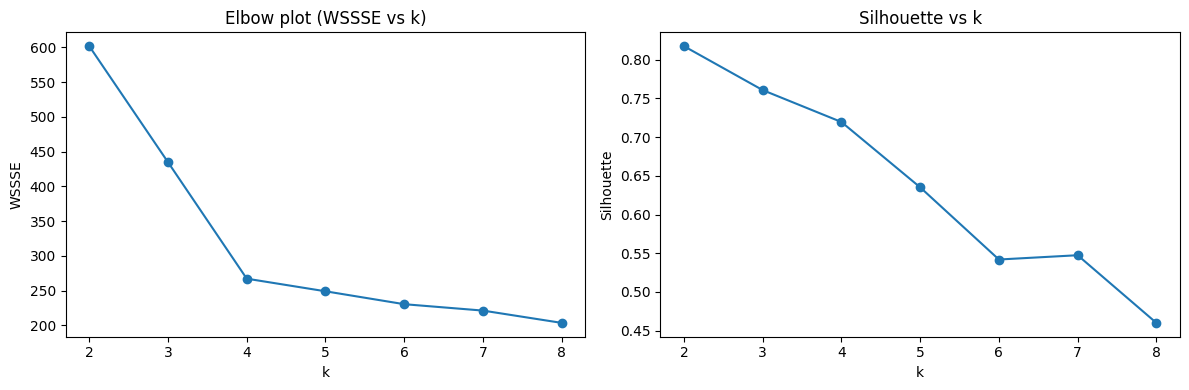

In [14]:
# Evaluar k en un rango y mostrar elbow + silhouette
k_values = list(range(2,9))
wss = []
silhs = []
for k in k_values:
    info = evaluate_k(df_scaled, k, seed=42)
    wss.append(info['wssse'])
    silhs.append(info['silhouette'])

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(k_values, wss, marker='o')
plt.xlabel('k')
plt.ylabel('WSSSE')
plt.title('Elbow plot (WSSSE vs k)')

plt.subplot(1,2,2)
plt.plot(k_values, silhs, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.title('Silhouette vs k')
plt.tight_layout()
plt.show()


### Interpretación del Elbow plot y la curva de Silhouette

En el caso de Elbow (WSSSE), la gráfica muestra una caída importante en la inercia al aumentar k desde 2 hasta 4, y luego las ganancias se reducen (disminución marginal menor para k>4). Esto sugiere que, desde la perspectiva de reducción de WSSSE, podría haber una "rodilla" alrededor de k=4 donde las mejoras se atenúan. Ahora bien con silhouette, la curva de Silhouette disminuye de forma consistente al incrementar k (≈0.82 en k=2, luego 0.76, 0.72, ... hasta ≈0.46 en k=8). Un valor de Silhouette más alto indica clusters más compactos y mejor separados; por tanto, k=2 maximiza esta métrica en nuestro rango probado.

En este caso el Elbow sugiere que aumentar k reduce la inercia, pero la métrica de calidad de separación (Silhouette) favorece fuertemente k=2. Dado que el objetivo forense incluye además la expectativa de cargas similares entre atacantes (cada atacante realiza aproximadamente la misma cantidad de intrusiones), la elección de k=2 es la más justificable: combina la mejor separación interna (Silhouette alta) con un balance cercano 50/50 observado en los tamaños de cluster.


In [15]:
feature_cols = ['Session_Connection_Time', 'Bytes_Transferred', 'Servers_Corrupted', 'Pages_Corrupted', 'WPM_Typing_Speed', 'Kali_Trace_Used']

# Medias y desviaciones desde Spark
means = np.array([df.selectExpr(f"avg({c}) as avg").collect()[0]['avg'] for c in feature_cols], dtype=float)
stds = np.array([df.selectExpr(f"stddev_pop({c}) as std").collect()[0]['std'] for c in feature_cols], dtype=float)

# Manejo de posibles ceros o nulos en std
stds = np.where(np.isnan(stds) | (stds == 0), 1.0, stds)

# Extraer centroides en espacio escalado desde los modelos
centers2_scaled = np.array([c for c in res2['model'].clusterCenters()])
centers3_scaled = np.array([c for c in res3['model'].clusterCenters()])

# Desescalar: original = scaled * std + mean
centers2_orig = centers2_scaled * stds + means
centers3_orig = centers3_scaled * stds + means

centers2_df = pd.DataFrame(centers2_orig, columns=feature_cols)
centers2_df.index.name = 'cluster'
print("Centroides (escala original) - k=2")
display(centers2_df)
centers3_df = pd.DataFrame(centers3_orig, columns=feature_cols)
centers3_df.index.name = 'cluster'
print("Centroides (escala original) - k=3")
display(centers3_df)

print("\nCentroides (k=2):")
for i, row in centers2_df.iterrows():
    print(f" Cluster {i}: Session_Connection_Time={row['Session_Connection_Time']:.2f} min, Bytes_Transferred={row['Bytes_Transferred']:.2f} MB, Servers_Corrupted={row['Servers_Corrupted']:.2f}, Pages_Corrupted={row['Pages_Corrupted']:.2f}, WPM={row['WPM_Typing_Speed']:.2f}, Kali_Used={row['Kali_Trace_Used']:.2f}")

print("\nCentroides (k=3):")
for i, row in centers3_df.iterrows():
    print(f" Cluster {i}: Session_Connection_Time={row['Session_Connection_Time']:.2f} min, Bytes_Transferred={row['Bytes_Transferred']:.2f} MB, Servers_Corrupted={row['Servers_Corrupted']:.2f}, Pages_Corrupted={row['Pages_Corrupted']:.2f}, WPM={row['WPM_Typing_Speed']:.2f}, Kali_Used={row['Kali_Trace_Used']:.2f}")


Centroides (escala original) - k=2


,Session_Connection_Time,Bytes_Transferred,Servers_Corrupted,Pages_Corrupted,WPM_Typing_Speed,Kali_Trace_Used
cluster,,,,,,
0,17.772850,377.820331,3.145087,7.854776,70.613023,0.497028
1,42.245114,836.670207,7.371919,13.821871,44.071767,0.526924


Centroides (escala original) - k=3


,Session_Connection_Time,Bytes_Transferred,Servers_Corrupted,Pages_Corrupted,WPM_Typing_Speed,Kali_Trace_Used
cluster,,,,,,
0,17.772850,377.820331,3.145087,7.854776,70.613023,0.497028
1,43.037271,846.492403,7.381247,13.779678,43.839351,0.999269
2,41.362712,825.729028,7.361528,13.868871,44.330662,0.000767



Centroides (k=2):
 Cluster 0: Session_Connection_Time=17.77 min, Bytes_Transferred=377.82 MB, Servers_Corrupted=3.15, Pages_Corrupted=7.85, WPM=70.61, Kali_Used=0.50
 Cluster 1: Session_Connection_Time=42.25 min, Bytes_Transferred=836.67 MB, Servers_Corrupted=7.37, Pages_Corrupted=13.82, WPM=44.07, Kali_Used=0.53

Centroides (k=3):
 Cluster 0: Session_Connection_Time=17.77 min, Bytes_Transferred=377.82 MB, Servers_Corrupted=3.15, Pages_Corrupted=7.85, WPM=70.61, Kali_Used=0.50
 Cluster 1: Session_Connection_Time=43.04 min, Bytes_Transferred=846.49 MB, Servers_Corrupted=7.38, Pages_Corrupted=13.78, WPM=43.84, Kali_Used=1.00
 Cluster 2: Session_Connection_Time=41.36 min, Bytes_Transferred=825.73 MB, Servers_Corrupted=7.36, Pages_Corrupted=13.87, WPM=44.33, Kali_Used=0.00


## **Graficas**

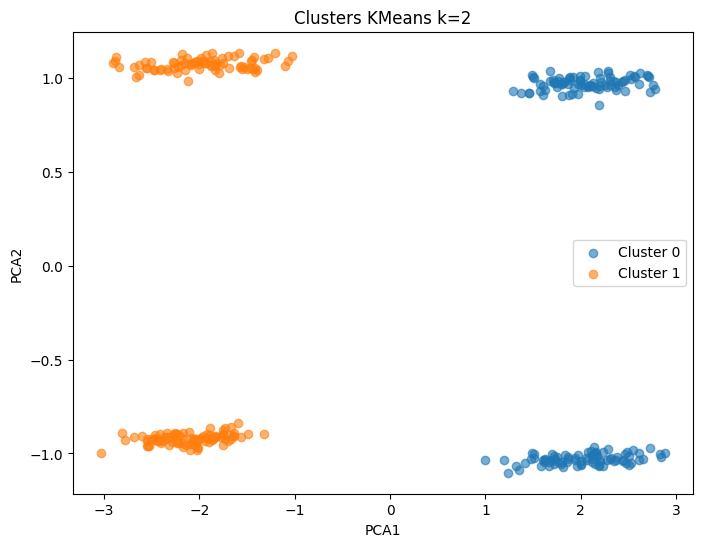

In [16]:
# Reducir features escaladas a 2 dimensiones para graficar
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled).select("row_id", "pca_features")

# Unir PCA con predicciones usando row_id para garantizar alineación antes de convertir a pandas
pred2 = res2['predictions'].select("row_id", "prediction")
joined2 = df_pca.join(pred2, on="row_id")
df_pd = joined2.toPandas()
# Extraer columnas PCA X e Y
df_pd['x'] = df_pd['pca_features'].apply(lambda v: v[0])
df_pd['y'] = df_pd['pca_features'].apply(lambda v: v[1])
df_pd['cluster'] = df_pd['prediction']

# Graficar clusters k=2
plt.figure(figsize=(8,6))
for cls in sorted(df_pd['cluster'].unique()):
    subset = df_pd[df_pd['cluster']==cls]
    plt.scatter(subset['x'], subset['y'], label=f'Cluster {cls}', alpha=0.6)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Clusters KMeans k=2")
plt.legend()
plt.show()


#### **Interpretación**

El gráfico de PCA para k=2 muestra dos grupos bien separados en el espacio reducido. En donde se observa que hay una clara división en dos bloques, ya que cada cluster tiene aproximadamente la misma cantidad de muestras (~50% / ~50%).Asimismo la separación indica diferencias coherentes en las características, con base en esta visualización y en el alto valor de Silhouette obtenido para k=2 (≈0.82), el modelo con k=2 es consistente y apoya la hipótesis de que probablemente hubo dos atacantes principales, cada uno responsable de cerca de la mitad de los eventos.


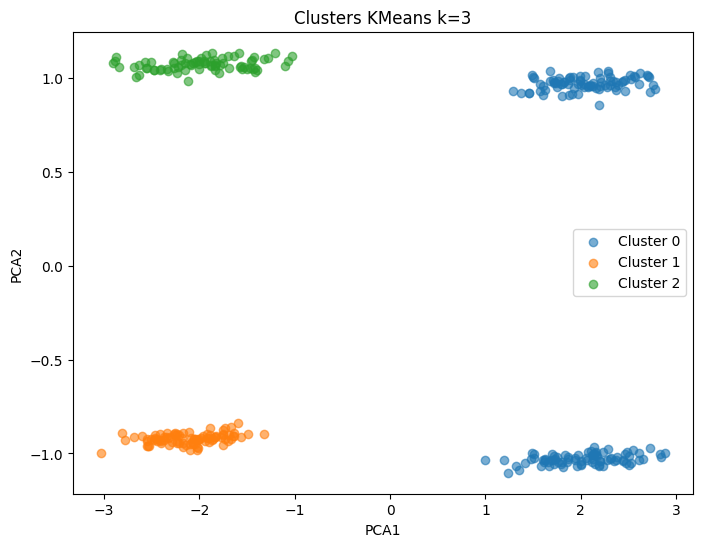

In [17]:
# Graficar clusters k=3 utilizando la misma PCA y uniendo por row_id
pred3 = res3['predictions'].select("row_id", "prediction")
joined3 = df_pca.join(pred3, on="row_id")
df_pd3 = joined3.toPandas()
# Extraer columnas PCA X e Y
df_pd3['x'] = df_pd3['pca_features'].apply(lambda v: v[0])
df_pd3['y'] = df_pd3['pca_features'].apply(lambda v: v[1])
df_pd3['cluster'] = df_pd3['prediction']

plt.figure(figsize=(8,6))
for cls in sorted(df_pd3['cluster'].unique()):
    subset = df_pd3[df_pd3['cluster']==cls]
    plt.scatter(subset['x'], subset['y'], label=f'Cluster {cls}', alpha=0.6)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Clusters KMeans k=3")
plt.legend()
plt.show()


#### **Interpretación**

El gráfico de PCA para k=3 muestra que, además de los dos grupos principales, aparece un tercer grupo más pequeño y relativamente separado. En donde las proporciones de los clusters fueron aproximadamente 50%, 26% y 24%. El Silhouette para k=3 es menor que para k=2 (≈0.76 vs ≈0.82), lo que indica clusters menos compactos y una separación menos clara. En este caso aunque existe un subgrupo adicional, su tamaño desigual y la caída del coeficiente Silhouette hacen menos convincente la hipótesis de tres atacantes con participación similar. Es más probable que haya dos atacantes dominantes y comportamientos adicionales que podrían reflejar variaciones en el mismo grupo o outliers.

## **Discusión de resultados**

Con respecto a los datos obtenidos, las métricas cuantitativas y las visualizaciones convergen en una interpretación coherente. En donde el coeficiente Silhouette que mide cuán bien separados están los clusters y cuán compactos son, arroja un valor notablemente mayor para k=2 (≈0.82) que para k=3 (≈0.76). En donde ese incremento sugiere que los clusters formados con k=2 son más coherentes internamente y más diferenciados entre sí. Por otro lado, la métrica WSSSE (inercia dentro de clusters) naturalmente disminuye cuando aumentamos k, pero la mejora marginal observada al pasar de k=2 a k=3 no compensa la reducción en la calidad de separación medida por Silhouette. En donde esto nos indica que dividir los datos en 3 grupos aporta menos ganancia en compacidad que la pérdida de claridad en la separación.

El balance de cargas entre clusters es otra pieza clave de la interpretación forense, ya que con  con k=2 observamos una distribución aproximadamente 50% / 50%, mientras que con k=3 aparecen proporciones desiguales (~50% / 26% / 24%). Dado que el equipo forense esperaba que varios atacantes se alternaran las intrusiones y, por tanto, que tuviesen participaciones similares, el resultado 50/50 es coherente con la hipótesis de dos atacantes repartiendo las sesiones. El esquema 50/26/24 es menos congruente con la expectativa de participación equilibrada de tres individuos.

Al examinar las gráficas PCA y los centroides , se aprecia que los clusters difieren en variables relevantes como número de servidores corrompidos, páginas accedidas, duración de la sesión y velocidad de tecleo. Esto ofrece una vía para perfilar a los grupos: por ejemplo, un cluster muestra sesiones más largas y mayor afectación (más servidores/páginas), mientras que el otro presenta sesiones más cortas y comportamientos diferentes en bytes transferidos y WPM. Para convertir esto en indicadores prácticos, consideramos que es recomendable desescalar los centroides (usar la media y desviación estándar del scaler) y presentar los valores en la escala original así los peritos podrán interpretar magnitudes (minutos, MB, conteos) en lugar de unidades estandarizadas.

## **Conclusión**
Con los datos y las pruebas realizadas, la evidencia cuantitativa y visual favorece la hipótesis de que dos atacantes fueron los principales responsables de las intrusiones, ya que la alta puntuación de Silhouette para k=2 y el balance cercano a 50/50 hacen esta opción más plausible que la alternativa de tres atacantes con participación similar.